# **Model Training**

We will going to use **`Random Forest Regressor` *

## 1) Import Data and Required Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [3]:
lettuce_df = pd.read_csv('data\lettuce_dataset.csv')
lettuce_df.head()

,Plant_ID,Date,Temperature,Humidity,TDS Value,pH Level,Growth Days
0,1,8/3/2023,33.4,53,582,6.4,1
1,1,8/4/2023,33.5,53,451,6.1,2
2,1,8/5/2023,33.4,59,678,6.4,3
3,1,8/6/2023,33.4,68,420,6.4,4
4,1,8/7/2023,33.4,74,637,6.5,5


In [4]:
# Convert 'Date' column to datetime and set it as index
lettuce_df['Date'] = pd.to_datetime(lettuce_df['Date'])
lettuce_df.set_index('Date', inplace=True)

# 2) Feature Engineering



## 2.1) Create new features

* We will use a lagged features, rolling window statistics and time-based features to add to our dataframe. 

    1. **`Lagged Features`** - We are storing the data in the previous days in another feature.
    2. **`Rolling window statistics`** - We are storing the mean (average) and standard deviation over 7-days.
    3. **`Time-Based Features`** - We are storing the pattern or variations of our data over time.
      

In [6]:
def create_lagged_features(df):
# Creating lagged features for Temperature, Humidity, pH Level, and TDS Value
    lag_features = ['Temperature', 'Humidity', 'TDS Value', 'pH Level']
    lags = [1, 2, 3, 7]  # Lags of 1 day, 2 days, 3 days, and 7 days

    for feature in lag_features:
        for lag in lags:
            df[f"{feature} Lag {lag}"] = df[feature].shift(lag)

    # Rolling window statistics for the same features
    window = 7  # 7-day window
    for feature in lag_features:
        df[f"{feature} Rolling Mean"] = df[feature].rolling(window=window).mean()
        df[f"{feature} Rolling Std"] = df[feature].rolling(window=window).std()

    # Time-based features
    df['Day of Week'] = df.index.dayofweek + 1
    df['Month'] = df.index.month

create_lagged_features(lettuce_df)

In [7]:
lettuce_df.head(10)

,Plant_ID,Temperature,Humidity,TDS Value,pH Level,Growth Days,Temperature Lag 1,Temperature Lag 2,Temperature Lag 3,Temperature Lag 7,...,Temperature Rolling Mean,Temperature Rolling Std,Humidity Rolling Mean,Humidity Rolling Std,TDS Value Rolling Mean,TDS Value Rolling Std,pH Level Rolling Mean,pH Level Rolling Std,Day of Week,Month
Date,,,,,,,,,,,,,,,,,,,,,
2023-08-03,1,33.4,53,582,6.4,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,8
2023-08-04,1,33.5,53,451,6.1,2,33.4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,8
2023-08-05,1,33.4,59,678,6.4,3,33.5,33.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,8
2023-08-06,1,33.4,68,420,6.4,4,33.4,33.5,33.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,8
2023-08-07,1,33.4,74,637,6.5,5,33.4,33.4,33.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,8
2023-08-08,1,32.3,77,478,6.8,6,33.4,33.4,33.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,8
2023-08-09,1,32.3,75,682,6.0,7,32.3,33.4,33.4,NaN,...,33.100000,0.547723,65.571429,10.453981,561.142857,110.617100,6.371429,0.262769,3,8
2023-08-10,1,22.7,63,576,6.3,8,32.3,32.3,33.4,33.4,...,31.571429,3.947875,67.000000,9.036961,560.285714,110.451670,6.357143,0.263674,4,8
2023-08-11,1,31.9,69,662,6.1,9,22.7,32.3,32.3,33.5,...,31.342857,3.863011,69.285714,6.600866,590.428571,104.275048,6.357143,0.263674,5,8


## 2.2) Create a function for evaluating of the performance of RandomForestRegressor

In [5]:
# Evaluate model's performance
def evaluate_performance(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    result_df = pd.DataFrame({
        'MSE': [mse],
        'RMSE': [rmse],
        'R2 Score': [r2]
    })
    
    return result_df

# 3) Train Test Split

In [6]:
# Removing rows with NaN values (due to lagged and rolling features)
cleaned_df = lettuce_df.dropna()

# Splitting the data into training and testing sets (80% train, 20% test)
X = cleaned_df.drop(['Growth Days', 'Plant_ID'], axis=1)
y = cleaned_df['Growth Days']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
cleaned_df.head()

,Plant_ID,Temperature,Humidity,TDS Value (ppm),pH Level,Growth Days,Temperature Lag 1,Temperature Lag 2,Temperature Lag 3,Temperature Lag 7,...,Temperature Rolling Mean,Temperature Rolling Std,Humidity Rolling Mean,Humidity Rolling Std,TDS Value (ppm) Rolling Mean,TDS Value (ppm) Rolling Std,pH Level Rolling Mean,pH Level Rolling Std,Day of Week,Month
Date,,,,,,,,,,,,,,,,,,,,,
2023-08-10,1,22.7,63,576,6.3,8,32.3,32.3,33.4,33.4,...,31.571429,3.947875,67.000000,9.036961,560.285714,110.451670,6.357143,0.263674,4,8
2023-08-11,1,31.9,69,662,6.1,9,22.7,32.3,32.3,33.5,...,31.342857,3.863011,69.285714,6.600866,590.428571,104.275048,6.357143,0.263674,5,8
2023-08-12,1,30.2,59,607,6.2,10,31.9,22.7,32.3,33.4,...,30.885714,3.767151,69.285714,6.600866,580.285714,97.575124,6.328571,0.269037,6,8
2023-08-13,1,30.1,77,670,6.5,11,30.2,31.9,22.7,33.4,...,30.414286,3.602975,70.571429,7.161404,616.000000,71.360587,6.342857,0.276026,7,8
2023-08-14,1,30.1,54,535,6.4,12,30.1,30.2,31.9,33.4,...,29.942857,3.354528,67.714286,9.250483,601.428571,76.580801,6.328571,0.269037,1,8


In [15]:
X_train.columns

Index(['Temperature', 'Humidity', 'TDS Value (ppm)', 'pH Level',
       'Temperature Lag 1', 'Temperature Lag 2', 'Temperature Lag 3',
       'Temperature Lag 7', 'Humidity Lag 1', 'Humidity Lag 2',
       'Humidity Lag 3', 'Humidity Lag 7', 'TDS Value (ppm) Lag 1',
       'TDS Value (ppm) Lag 2', 'TDS Value (ppm) Lag 3',
       'TDS Value (ppm) Lag 7', 'pH Level Lag 1', 'pH Level Lag 2',
       'pH Level Lag 3', 'pH Level Lag 7', 'Temperature Rolling Mean',
       'Temperature Rolling Std', 'Humidity Rolling Mean',
       'Humidity Rolling Std', 'TDS Value (ppm) Rolling Mean',
       'TDS Value (ppm) Rolling Std', 'pH Level Rolling Mean',
       'pH Level Rolling Std', 'Day of Week', 'Month'],
      dtype='object')

# 4) Feature Transformation

In [9]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Show the first few rows of the scaled training data
pd.DataFrame(X_train_scaled, columns=X.columns)

,Temperature,Humidity,TDS Value (ppm),pH Level,Temperature Lag 1,Temperature Lag 2,Temperature Lag 3,Temperature Lag 7,Humidity Lag 1,Humidity Lag 2,...,Temperature Rolling Mean,Temperature Rolling Std,Humidity Rolling Mean,Humidity Rolling Std,TDS Value (ppm) Rolling Mean,TDS Value (ppm) Rolling Std,pH Level Rolling Mean,pH Level Rolling Std,Day of Week,Month
0,0.761290,0.466667,0.9625,0.625,0.780645,0.780645,0.780645,0.922581,0.000000,0.333333,...,0.720251,0.469936,0.554054,0.905331,0.539726,0.590884,0.692308,0.165423,0.333333,0.0
1,0.993548,0.700000,0.3325,1.000,1.000000,0.993548,0.870968,0.851613,0.466667,0.000000,...,0.897704,0.264313,0.432432,0.536154,0.722192,0.767915,0.512821,0.834248,0.833333,0.0
2,0.922581,0.833333,0.5075,0.500,0.993548,0.993548,0.993548,0.870968,0.100000,0.233333,...,0.923800,0.496978,0.378378,0.651882,0.464658,0.547919,0.307692,0.536682,0.166667,0.0
3,0.722581,0.533333,0.7575,0.875,0.716129,0.690323,0.735484,0.858065,0.600000,0.766667,...,0.766180,0.152726,0.405405,0.562938,0.411507,0.692920,0.410256,0.616815,0.500000,0.0
4,0.154839,0.233333,0.9175,0.250,0.258065,0.380645,0.303226,0.335484,0.566667,0.500000,...,0.194154,0.223253,0.344595,0.373791,0.738630,0.742773,0.153846,0.334698,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2524,0.290323,0.133333,0.0700,0.875,0.109677,0.374194,0.245161,0.167742,0.000000,0.533333,...,0.197286,0.298973,0.094595,0.299938,0.202192,0.237772,0.615385,0.380510,0.500000,0.0
2525,0.780645,0.466667,0.2575,0.875,0.787097,0.896774,0.303226,0.993548,0.900000,0.866667,...,0.803758,0.575399,0.689189,0.538207,0.391781,0.503190,0.435897,0.663508,1.000000,0.0
2526,0.993548,0.133333,0.1450,0.375,0.870968,0.812903,0.716129,0.845161,0.266667,0.033333,...,0.850731,0.185943,0.364865,0.802301,0.413699,0.754212,0.461538,0.507815,0.500000,0.0
2527,0.883871,0.200000,0.5650,0.750,0.722581,0.716129,0.690323,0.864516,0.566667,0.100000,...,0.769311,0.164791,0.533784,0.667243,0.419178,0.744148,0.333333,0.458801,0.666667,1.0


# **Building Random Forest Regressor Model**

In [10]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_rf_pred = rf_model.predict(X_test_scaled)

rf_score = evaluate_performance(y_test, y_rf_pred)

rf_score

,MSE,RMSE,R2 Score
0,11.823845,3.438582,0.930976


### **Random Forest Regressor Model**
*  **`Mean Squared Error`** - 11.8582: This metric emphasizes larger errors over smaller ones, which means that low value indicates a strong model fit.
*  **`Root Mean Squared Error`** - 3.45: This indicates that the model's predictions are off by 3.45 days.
*  **`R2 Score`** - 0.93016: This value is 93% accuracy.

In [11]:
#Check for the comparison of actual and predicted values
actual_values = pd.DataFrame({
    'Actual Values': y_test,
}).reset_index(drop=True)


rf_model_values = pd.DataFrame({
    'Random Forest Predicted Values': y_rf_pred
}).reset_index(drop=True)


model_values_comparison = pd.concat([actual_values, rf_model_values], axis=1)
model_values_comparison

,Actual Values,Random Forest Predicted Values
0,10,10.00
1,6,6.00
2,24,24.00
3,23,23.00
4,12,12.00
...,...,...
628,15,15.65
629,18,18.00
630,38,38.68
631,41,36.87


### **Observation:**
* We can see here that among the three models, the most exact and nearest prediction values to the actual values is the **`Random Forest Regressor`** 

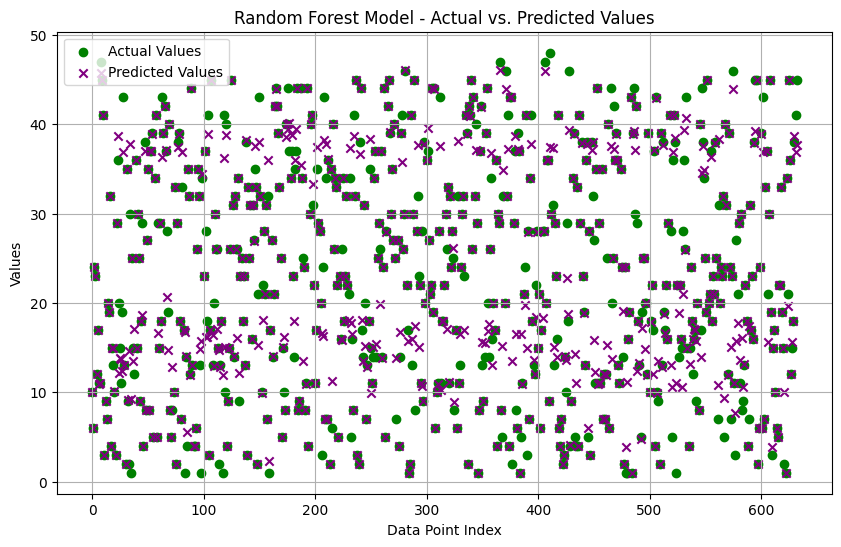

In [12]:
# Scatter plot for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(model_values_comparison.index, model_values_comparison['Actual Values'], color='green', label='Actual Values', marker='o')
plt.scatter(model_values_comparison.index, model_values_comparison['Random Forest Predicted Values'], color='purple', label='Predicted Values', marker='x')
plt.xlabel('Data Point Index')
plt.ylabel('Values')
plt.title('Random Forest Model - Actual vs. Predicted Values')
plt.legend()
plt.grid()
plt.show()

### Observation:


   *  We can see that in our `Random Forest Regressor` Scatterplot, our predicted values are overlapping with the actual values giving us a realistic values and a higher accuracy.


### Difference between Actual and Predicted Values

In [13]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_rf_pred,'Difference':y_test-y_rf_pred})
pred_df

,Actual Value,Predicted Value,Difference
Date,,,
2023-08-12,10,10.00,0.00
2023-08-08,6,6.00,0.00
2023-08-26,24,24.00,0.00
2023-08-25,23,23.00,0.00
2023-08-14,12,12.00,0.00
...,...,...,...
2023-08-17,15,15.65,-0.65
2023-08-20,18,18.00,0.00
2023-09-09,38,38.68,-0.68
